# Assignment 6 - ASTP-720 - Brendan Drachler

This notebook contains all of the work for Assignment 6 in Comp. Astrophysics (ASTP-720).

In [18]:
## Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from PyAstronomy.pyasl import foldAt
import scipy.signal


## Optimize for Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Read in the datasets.
RV_data = np.loadtxt('RV_data.txt',skiprows=16,usecols=(0,1,2,3,4))
lightcurve_data = np.loadtxt('lightcurve_data.txt',skiprows=18,usecols=(0,1))

In [19]:
## Export the values from the datasets
BJD = RV_data[:,0]
Rad_Vel = RV_data[:,1]
Rad_Vel_Uncert = RV_data[:,2]
Bisect_Span = RV_data[:,3]
BS_Uncert = RV_data[:,4]

HJD = lightcurve_data[:,0]
flux = lightcurve_data[:,1]

## Plot the data!

array([2454953.538373, 2454953.558807, 2454953.579242, ...,
       2454997.9424  , 2454997.962835, 2454997.983269])

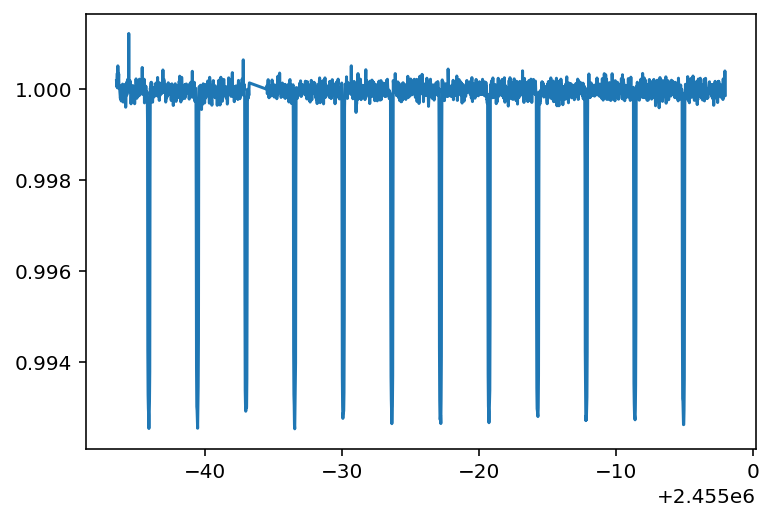

In [416]:
plt.plot(HJD, flux)
HJD

## Fold the lightcurve and plot the result

3.548161090944301


Text(0, 0.5, 'Relative Intensity')

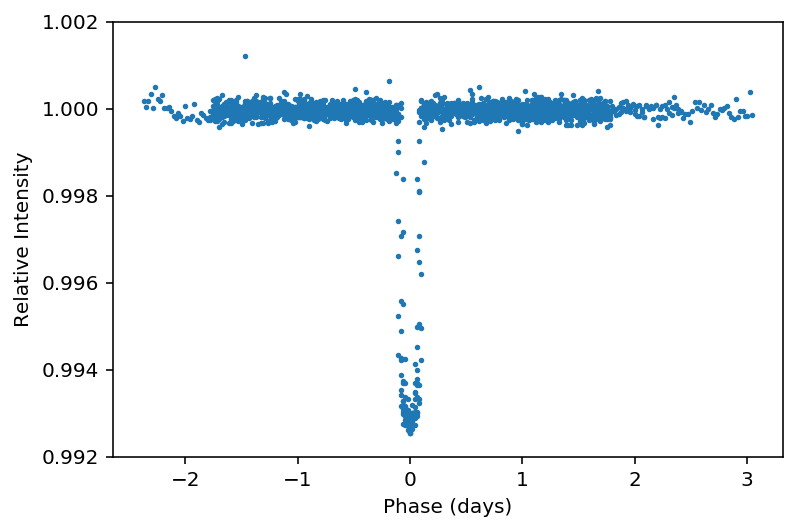

In [428]:
## Identify the peaks in the 1/flux signal (i.e. the valleys!)
peak_index = scipy.signal.find_peaks(1/flux, distance=100)[0]

## The function above extracts two garbage datapoints at the beginning and end of the array
## Throw those away!
peak_index = peak_index[1:-1]

## Define the period as the mean distance between consecutive valleys.
period = np.mean(np.ediff1d(HJD[peak_index]))
print(period)

new_HJD = []

def find_nearest_value(peak_indices, times):
    '''
    Summary:
    Sorry for the lengthy explanation incoming but building this function was
    very confusing for me!
    
    The goal here was to chunk the the data after every period, P and 
    stack the data into a single phase. In order to do that, I need to identify 
    which datapoints belong to which period, N. 
    
    This function does that computation. Thanks to this stack overflow thread for
    the nice explanation:
    
    https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array

    Parameters
    ----------
    peak_indices : the index of each peak (valley).
    times : the HJD dates.
    '''
    indices = np.abs(np.subtract.outer(peak_indices, times)).argmin(0)
    return peak_indices[indices]

## Shift the data into a single phase as described in my ramblings above.
for i in range(len(flux)):
    shifted_index = find_nearest_value(peak_index,i)
    new_HJD.append(HJD[i]-HJD[shifted_index])
    
## Plot the data.
plt.scatter(new_HJD,flux,s=3)
plt.ylim(0.992,1.002)
plt.xlabel('Phase (days)')
plt.ylabel('Relative Intensity')

In [429]:
def dip_model(theta, x):
    '''
    Summary:
    Defining my boxcar dip model. If the data is in the single valley,
    it's equal to the amplitude at the bottom of the valley.
    
    If not, it's equal to 1.

    Parameters
    ----------
    theta : array, contains the two fitting parameters - the valley width and amplitude.
    '''
    
    width, amp_I = theta
    
    temp_model = []
    
    ## Compute the value of the model.
    for i in range(len(x)):
        if x[i] > -width/2 and x[i] < width/2:
            temp_model.append(amp_I)
        else: 
            temp_model.append(1)
    
    return temp_model
    
def lnprior(theta):
    '''
    Summary:
    Define the prior distribution.
    Parameters
    ----------
    theta : array, contains the two fitting parameters - the valley width and amplitude.
    ''' 
    
    # The parameters are stored as a vector of values, so unpack them
    width, amp_I = theta
    
    ## Bound the priors.
    if width < 0 or width > 0.4:
        return -np.inf
    if amp_I < 0.98 or amp_I > 1.0:
        return -np.inf
    
    
    return 0


def lnlike(theta, x, y):
    '''
    Summary:
    Define the log likelihood.
    Parameters
    ----------
    theta : array, contains the two fitting parameters - the valley width and amplitude.
    x : the x-data that we will use to fit.
    y : the y-data that we will use to fit.
    ''' 
    
    model = dip_model(theta, x)
    
    
    # the likelihood is sum of the lot of normal distributions
    denom = np.sqrt(2*np.pi)
    
    ## compute the likelihood.
    lp = np.sum((-(y - model)**2.0/(2)) - np.log(denom))
    return lp

def lnprob(theta, x, y):
    '''
    Summary:
    Define the log likelihood.
    Parameters
    ----------
    theta : array, contains the two fitting parameters - the valley width and amplitude.
    x : the x-data that we will use to fit.
    y : the y-data that we will use to fit.
    ''' 
    
    ## Keep us bounded by our priors.
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    ## Compute the log probability.
    return lp + lnlike(theta, x, y)
    

In [440]:
def mcmc(nsteps, ndim, theta0, posterior, posterior_args=()):
    """
    Run an MCMC Metropolis-Hastings Algorithm
    
    Parameters
    ----------
    nsteps : The number of iterations to take.
    ndim : The number of parameters we are fitting for.
    theta0 : The initial guess at the parameters.
    posterior : The posterior distribution.
    """
    
    ## Initialize the chain with the starting values passed to the function.
    chain = np.zeros((nsteps, ndim))
    chain[0] = theta0
    
    ## Store the log_likelihoods.
    ln_lk = np.zeros(nsteps)
    ln_lk[0] = lnprob(chain[0], *posterior_args)
    
    ## Loop over the specified number of steps 
    for i in range(1, nsteps):
        
        ## Perturb our initial guess by a random amount to explore the parameter space.
        theta_new = chain[i - 1] + [0.001,0.0001] * np.random.randn(ndim)
        
        ## Update the probability.
        ln_lk_update = lnlike(theta_new, *posterior_args)
        
        ## Compute the difference between the updated probability and the 
        ## previous probability.
        log_p_accept = ln_lk_update - ln_lk[i - 1]
        
        ## Define the Metropolis Ratio as in Eq. 1 of Michael Lam's M-H Notes.
        ## Also, this article becomes helpful at this point: 
        ## https://wiseodd.github.io/techblog/2015/10/17/metropolis-hastings/
        r = np.random.rand()
        
        ## Perform the acceptance step as in Eq. 2 of Michael Lam's M-H Notes.
        if log_p_accept > np.log(r):
            chain[i] = theta_new
            ln_lk[i] = ln_lk_update
        else:
            chain[i] = chain[i - 1]
            ln_lk[i] = ln_lk[i - 1]
            
    ## Return the chain for plotting
    return chain

## Run the MCMC!!

In [456]:
chain = mcmc(10000, 2, [0.2, 0.9955], lnprior, (new_HJD, flux))

## Plot a 2D Histrogram

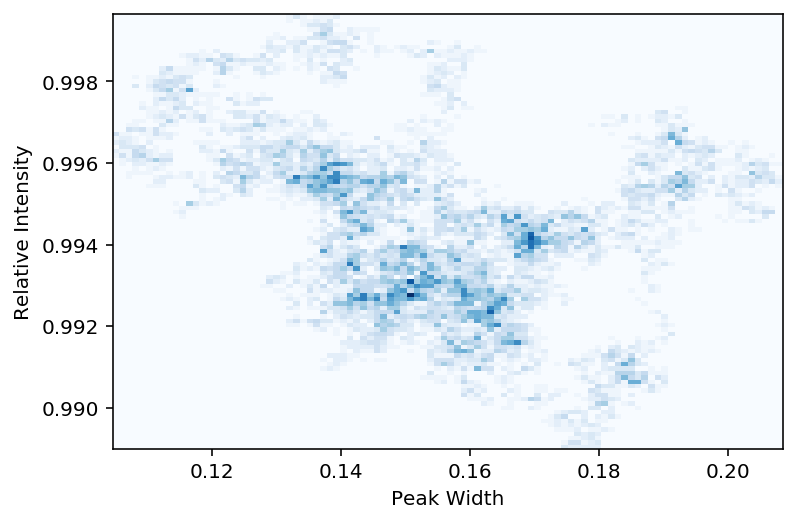

In [462]:
plt.hist2d(chain[:, 0], chain[:, 1], bins=100,
           cmap='Blues')
plt.xlabel('Peak Width')
plt.ylabel('Relative Intensity')
plt.grid(False);

## Plot 1D Histograms!

Text(0, 0.5, 'Frequency')

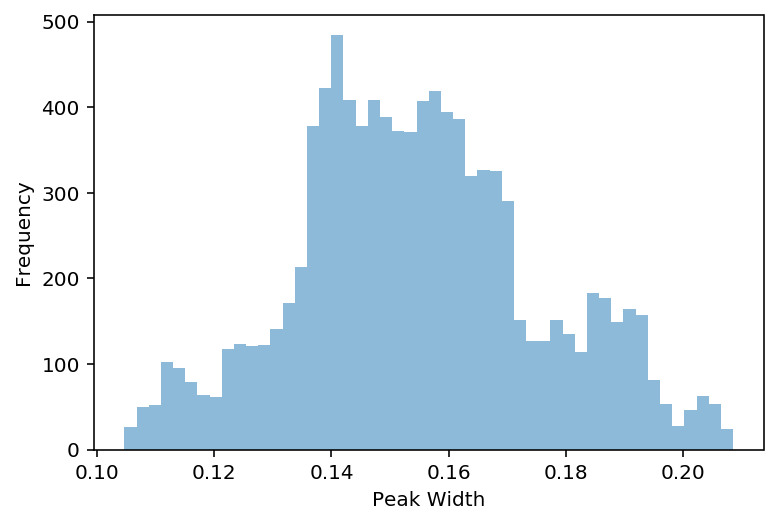

In [471]:
plt.hist(chain[:, 0], alpha=0.5, bins=50)
plt.xlabel('Peak Width')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

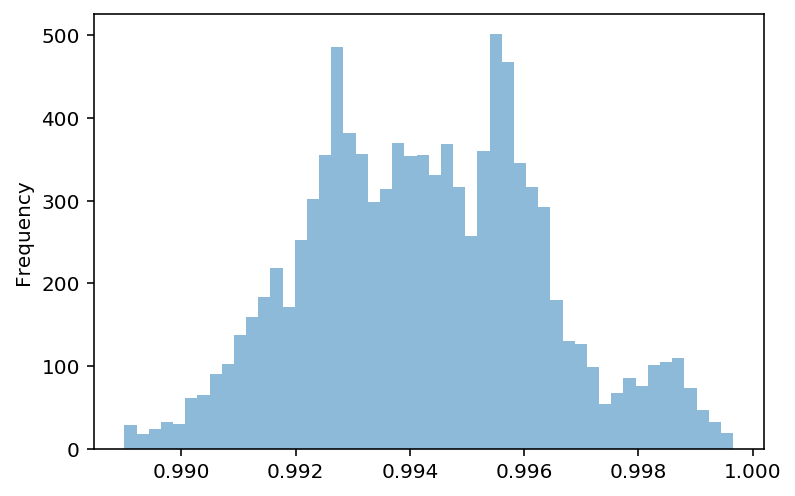

In [472]:
plt.hist(chain[:, 1], alpha=0.5, bins=50)
plt.ylabel('Relative Intensity')
plt.ylabel('Frequency')

In [478]:
theta_best = chain.mean(0)
theta_best

array([0.15484564, 0.99428275])

## Plot the model on top of the Data

Text(0, 0.5, 'Relative Intensity')

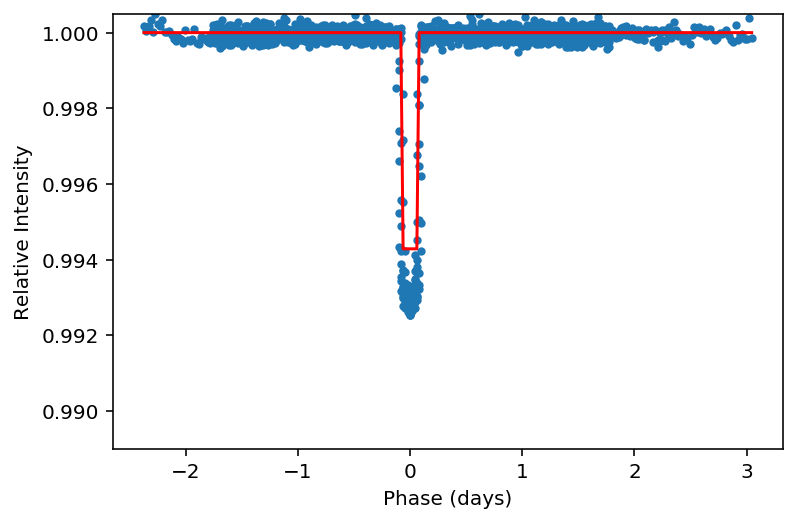

In [476]:
plt.scatter(new_HJD,flux,s=10)
plt.plot(sorted(new_HJD), dip_model(theta_best, sorted(new_HJD)), 'r')
plt.ylim(0.989,1.0005)
plt.xlabel('Phase (days)')
plt.ylabel('Relative Intensity')

## Calculate the planet's radius

In [480]:
def planet_radii_calc(intensity):
    return np.sqrt(1.79**2.0 * (1-intensity))

In [481]:
planet_radii_calc(theta_best[1])

0.13534643011274722